<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
#For use during testing:
#!pip install leidenalg
#!pip install --index-url https://test.pypi.org/simple/ modisco

!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

## Grab the input data

In [4]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [3]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict
import numpy as np

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #len(fasta_sequences) #100 #since this is just a test run, for speed I am limiting to 100 sequences
#reverse-complement some of the sequences to simulate that
take_rc = (np.random.RandomState(1234).uniform(size=n) > 0.5)
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                            for x,rc in zip(f['contrib_scores'][task][:n], take_rc)]
    task_to_hyp_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                                for x,rc in zip(f['hyp_contrib_scores'][task][:n], take_rc)]

onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

Double check by plotting

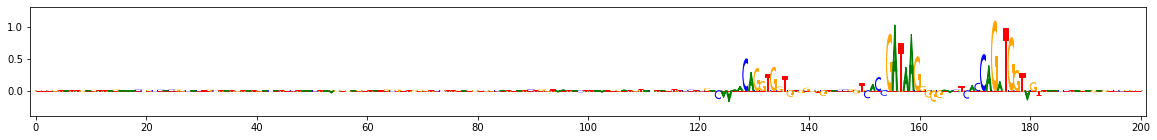

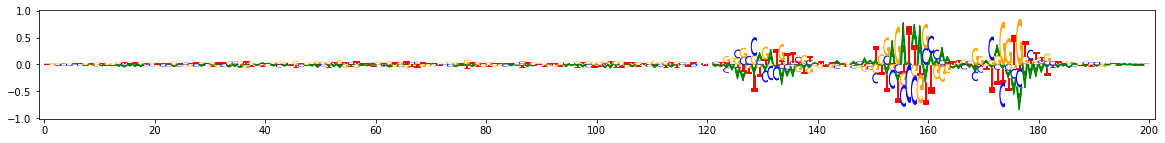

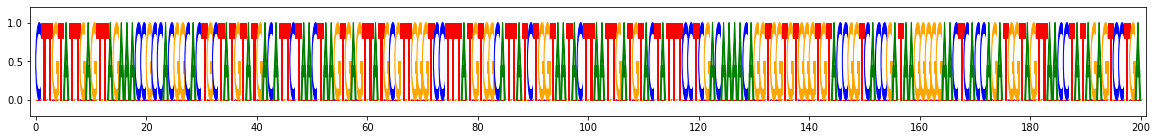

In [7]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. If all three tasks are specified under "task_names", then there will be 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). If only task0 is specified, there will only be two possible metaclusters (+1 and -1). In recent years, we have moved towards running tfmodisco on a single task at a time, which is why the example below just uses task0 (which turns up both the TAL and GATA motifs).

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 15 rather than the default of 30. After the trimming is done, the motif is expanded on either side by initial_flank_to_add. This is set to 5 rather than the default of 10. At the very end of the pipeline, once the motifs have all been processed (e.g. they have been put through the redundancy reduction and filtering steps), the flanks are expanded even further by final_flank_to_add (this is useful for revealing subtle flanking sequences that may be associated with the motif). By default, final_flank_to_add is set to 0; here, we set it to 5. The final motif length is trim_to_window_size + 2 x initial_flank_to_add + 2 x final_flank_to_add.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.282492928
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02277598052151734
Computing threshold
For increasing = True , the minimum IR precision was 0.14668684157935308 occurring at 7.078051567077637e-06 implying a frac_neg of 0.17190270668138782
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4483100377790805 occurring at -1.0013580322265625e-05 implying a frac_neg of 0.812612279502665
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -1.0124836564064026  and  0.898599348962307 with frac passing 0.15951612903225806
Final raw thresholds are -1.0124836564064026  and  0.898599348962307
Final transformed thresholds are -0.8494086021505376  and  0.8400537634408602


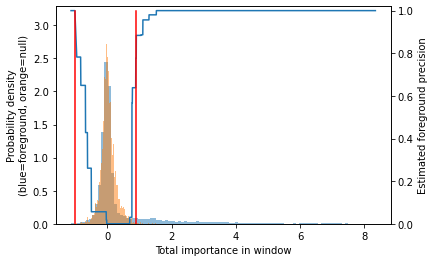

Got 198 coords
After resolving overlaps, got 198 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8399537634408603
MEMORY 0.282570752
198 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [195]
Idx to activities:  {0: '1'}
MEMORY 0.282570752
On metacluster 0
Metacluster size 195
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
Using pynnd for nearest neighbor cosine sims
2021-12-08 16:25:22.544316 TfModiscoSeqletsToPatternsFactory: seed=1234
2021-12-08 16:25:22.607492 (Round 1) num seqlets: 195
2021-12-08 16:25:22.607753 (Round 1) Computing coarse affmat
MEMORY 0.282570752
Beginning embedding computation
MEMORY 0.282570752
At the beginning of embedding call
MEMORY 0.282570752
before computing embeddings fwd
MEMORY 0.282570752


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 176 out of 195 | elapsed:    4.1s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    4.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


after computing embeddings fwd
MEMORY 0.282656768


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.0s


after computing embeddings rev
MEMORY 0.283222016
before computing sparse embeddings fwd
MEMORY 0.283222016
Constructing csr matrix...
csr matrix made in 0.029452085494995117 s
after computing sparse embeddings fwd
MEMORY 0.283635712
before computing sparse embeddings rev
MEMORY 0.283635712
Constructing csr matrix...
csr matrix made in 0.027006864547729492 s
after computing sparse embeddings rev
MEMORY 0.285200384
Finished embedding computation in 8.85 s
MEMORY 0.285200384
Starting affinity matrix computations
MEMORY 0.285200384


[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    4.3s finished


2021-12-08 16:25:34.584823 Building the index


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2021-12-08 16:25:41.458171 Preparing the index
2021-12-08 16:25:49.582227 Index ready
2021-12-08 16:25:49.583147 Querying neighbors for fwd
2021-12-08 16:25:49.791538 Querying neighbors for rev
2021-12-08 16:25:49.947780 Unifying fwd and rev
Finished affinity matrix computations in 18.51 s
MEMORY 0.4156416
2021-12-08 16:25:50.069270 (Round 1) Computed coarse affmat
MEMORY 0.4156416
2021-12-08 16:25:50.070282 (Round 1) Computing fine-grained affinity matrix
MEMORY 0.4156416
2021-12-08 16:25:50.093993 Building the index
Wed Dec  8 16:25:59 2021 NN descent for 8 iterations
	 1  /  8
	 2  /  8
	 3  /  8
	 4  /  8
	Stopping threshold met -- exiting after 4 iterations
2021-12-08 16:30:55.748798 Preparing the index
Wed Dec  8 16:31:21 2021 Forward diversification reduced edges from 5850 to 1073
Wed Dec  8 16:31:46 2021 Reverse diversification reduced edges from 1073 to 1073
Wed Dec  8 16:31:46 2021 Degree pruning reduced edges from 1168 to 1168
Wed Dec  8 16:31:46 2021 Resorting data and grap

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.2s


Quality: 0.47481800694792065
2021-12-08 16:32:04.044195 Got 2 clusters after round 1
Counts:
{0: 108, 1: 87}
MEMORY 1.72722176
2021-12-08 16:32:04.044996 (Round 1) Aggregating seqlets in each cluster
MEMORY 1.72722176
2021-12-08 16:32:04.045717 Aggregating for cluster 0 with 108 seqlets
MEMORY 1.72722176
Skipped 1 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.9s finished


Skipped 12 seqlets that went over sequence edge during flank expansion
Skipped 6 due to duplicates
Trimming eliminated 0 seqlets out of 89
Skipped 13 seqlets that went over the sequence edge during flank expansion
2021-12-08 16:32:04.275176 Aggregating for cluster 1 with 87 seqlets
MEMORY 1.72722176
Skipped 8 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplicates
Trimming eliminated 0 seqlets out of 77
Skipped 4 seqlets that went over the sequence edge during flank expansion
2021-12-08 16:32:04.571499 (Round 2) num seqlets: 149
2021-12-08 16:32:04.571687 (Round 2) Computing coarse affmat
MEMORY 1.72722176
Beginning embedding computation
MEMORY 1.72722176
At the beginning of embedding call
MEMORY 1.72722176
before computing embeddings fwd
MEMORY 1.72722176


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 130 out of 149 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 149 out of 149 | elapsed:    3.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


after computing embeddings fwd
MEMORY 1.72763136


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 130 out of 149 | elapsed:    3.4s remaining:    0.5s


after computing embeddings rev
MEMORY 1.727807488
before computing sparse embeddings fwd
MEMORY 1.727807488
Constructing csr matrix...
csr matrix made in 0.02302098274230957 s
after computing sparse embeddings fwd
MEMORY 1.727807488
before computing sparse embeddings rev
MEMORY 1.727807488
Constructing csr matrix...
csr matrix made in 0.02253890037536621 s
after computing sparse embeddings rev
MEMORY 1.727807488
Finished embedding computation in 6.99 s
MEMORY 1.727807488
Starting affinity matrix computations
MEMORY 1.727807488
2021-12-08 16:32:11.564784 Building the index


[Parallel(n_jobs=10)]: Done 149 out of 149 | elapsed:    3.6s finished


2021-12-08 16:32:11.967167 Preparing the index
2021-12-08 16:32:13.069379 Index ready
2021-12-08 16:32:13.070043 Querying neighbors for fwd
2021-12-08 16:32:13.215818 Querying neighbors for rev
2021-12-08 16:32:13.322822 Unifying fwd and rev
Finished affinity matrix computations in 1.77 s
MEMORY 1.733050368
2021-12-08 16:32:13.472760 (Round 2) Computed coarse affmat
MEMORY 1.733050368
2021-12-08 16:32:13.473709 (Round 2) Computing fine-grained affinity matrix
MEMORY 1.733050368
2021-12-08 16:32:13.491784 Building the index
Wed Dec  8 16:32:18 2021 NN descent for 7 iterations
	 1  /  7
	 2  /  7
	Stopping threshold met -- exiting after 2 iterations
2021-12-08 16:37:14.582777 Preparing the index
Wed Dec  8 16:37:40 2021 Forward diversification reduced edges from 4470 to 768
Wed Dec  8 16:38:05 2021 Reverse diversification reduced edges from 768 to 768
Wed Dec  8 16:38:05 2021 Degree pruning reduced edges from 834 to 834
Wed Dec  8 16:38:05 2021 Resorting data and graph based on tree orde

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.3s


Quality: 0.4891883685012036
2021-12-08 16:38:17.088590 Got 2 clusters after round 2
Counts:
{0: 77, 1: 72}
MEMORY 2.51047936
2021-12-08 16:38:17.089513 (Round 2) Aggregating seqlets in each cluster
MEMORY 2.51047936
2021-12-08 16:38:17.090255 Aggregating for cluster 0 with 77 seqlets
MEMORY 2.51047936
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 76
2021-12-08 16:38:17.237044 Aggregating for cluster 1 with 72 seqlets
MEMORY 2.51047936


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.1s finished


Trimming eliminated 0 seqlets out of 72
2021-12-08 16:38:17.357253 Got 2 clusters
2021-12-08 16:38:17.357355 Splitting into subclusters...
MEMORY 2.51047936
Inspecting pattern 0 for spurious merging
[t-SNE] Computed conditional probabilities for sample 76 / 76
[t-SNE] Mean sigma: 0.437895
Beginning preprocessing + Leiden
Affmat shape: 76


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.3s


Quality: 0.12726015917223382
Quality: 0.1294658147202889
Got subclusters: Counter({0: 24, 2: 19, 1: 19, 3: 14})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.0s finished


Numbers for each pattern pre-subsample: [24, 19, 19, 14]
Numbers after subsampling: [24, 19, 19, 14]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.0869607925415039 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.05713677406311035 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.05613064765930176 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.05367588996887207 s
Cluster sizes
[24 19 19 14]
Cross-contamination matrix:
[[1.   0.77 0.84 0.54]
 [0.56 1.   0.78 0.51]
 [0.63 0.75 1.   0.53]
 [0.53 0.74 0.73 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.95 0.96 0.92]
 [0.95 1.   0.96 0.96]
 [0.96 0.96 1.   0.96]
 [0.92 0.96 0.96 1.  ]]
Collapsing 1 & 2 with crosscontam 0.7532784432286432 and sim 0.9637351390285216
Collapsing 0 & 2 with crosscontam 0.6282742868250961 and sim 0.962135878706076
Collapsing 1 & 3 with crosscontam 0.5127361339637182 and sim 0.9612429020457233
Collapsing 2 & 3 with crosscontam 0.5331472726136672 and sim

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s


Quality: 0.09128511983715709
Quality: 0.09137694416978531
Got subclusters: Counter({0: 24, 1: 23, 2: 21, 3: 4})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.9s finished


Numbers for each pattern pre-subsample: [24, 23, 21, 4]
Numbers after subsampling: [24, 23, 21, 4]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.0780940055847168 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.06614923477172852 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.06319689750671387 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.028528213500976562 s
Cluster sizes
[24 23 21  4]
Cross-contamination matrix:
[[1.   0.8  0.66 0.23]
 [0.78 1.   0.63 0.11]
 [0.85 0.89 1.   0.23]
 [0.3  0.21 0.21 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.96 0.96 0.61]
 [0.96 1.   0.97 0.58]
 [0.96 0.97 1.   0.58]
 [0.61 0.58 0.58 1.  ]]
Collapsing 1 & 2 with crosscontam 0.6348475775614757 and sim 0.9746830356463345
Collapsing 0 & 2 with crosscontam 0.6624366181657848 and sim 0.9601539023085734
Collapsing 0 & 1 with crosscontam 0.7827319799457548 and sim 0.9580161257074228
Trimming eliminated 0 seqlets out of 44
Trimming eliminated 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  56 out of  75 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the de

[t-SNE] Iteration 550: error = 0.6459602, gradient norm = 0.0002811 (50 iterations in 0.022s)
[t-SNE] Iteration 600: error = 0.6266843, gradient norm = 0.0005242 (50 iterations in 0.021s)
[t-SNE] Iteration 650: error = 0.6114156, gradient norm = 0.0004646 (50 iterations in 0.020s)
[t-SNE] Iteration 700: error = 0.5746815, gradient norm = 0.0011338 (50 iterations in 0.015s)
[t-SNE] Iteration 750: error = 0.1927636, gradient norm = 0.0268420 (50 iterations in 0.016s)
[t-SNE] Iteration 800: error = 0.1435702, gradient norm = 0.0039885 (50 iterations in 0.015s)
[t-SNE] Iteration 850: error = 0.1433084, gradient norm = 0.0011092 (50 iterations in 0.012s)
[t-SNE] Iteration 900: error = 0.1432508, gradient norm = 0.0005576 (50 iterations in 0.011s)
[t-SNE] Iteration 950: error = 0.1432163, gradient norm = 0.0007375 (50 iterations in 0.012s)
[t-SNE] Iteration 1000: error = 0.1432994, gradient norm = 0.0007485 (50 iterations in 0.010s)
[t-SNE] KL divergence after 1000 iterations: 0.143299
[t-SN

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s


Quality: 0.11043532035704277


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  68 out of  68 | elapsed:    0.0s finished


Got subclusters: Counter({0: 22, 1: 20, 2: 19, 3: 14})
2021-12-08 16:38:24.889964 On pattern 1
[t-SNE] Computing 67 nearest neighbors...
[t-SNE] Indexed 68 samples in 0.001s...
[t-SNE] Computed neighbors for 68 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 68 / 68
[t-SNE] Mean sigma: 0.515196
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 46.8752060, gradient norm = 0.6063210 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 48.6437531, gradient norm = 0.5394424 (50 iterations in 0.012s)
[t-SNE] Iteration 150: error = 54.4451675, gradient norm = 0.5694275 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 50.1584473, gradient norm = 0.5321829 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 50.8634148, gradient norm = 0.4590794 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.863415
[t-SNE] Iteration 300: error = 0.7801142, gradient norm = 0.0015718 (50 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s


Quality: 0.07381649568702617
Quality: 0.0738790821191525
Quality: 0.07393822593908787
Got subclusters: Counter({0: 19, 1: 17, 2: 16, 3: 16})


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.8s finished


In [7]:
import h5py
import numpy as np
%matplotlib inline
import modisco

#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.pattern_filterer)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_flank_to_add=5,
                        final_min_cluster_size=60,
                        #use_pynnd=True can be used for faster nn comp at coarse grained step
                        # (it will use pynndescent), but note that pynndescent may crash
                        use_pynnd=True, 
                        n_cores=10)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores=null_per_pos_scores)

## Save Results

In [8]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


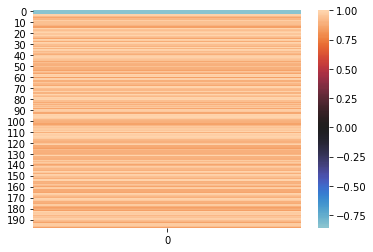

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 75
Task 0 hypothetical scores:


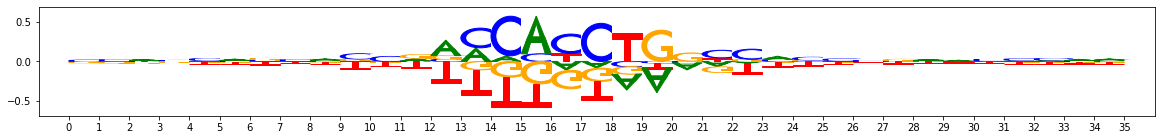

Task 0 actual importance scores:


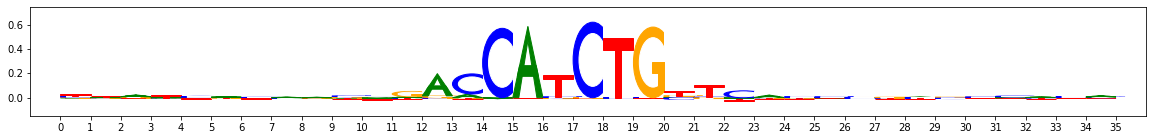

onehot, fwd and rev:


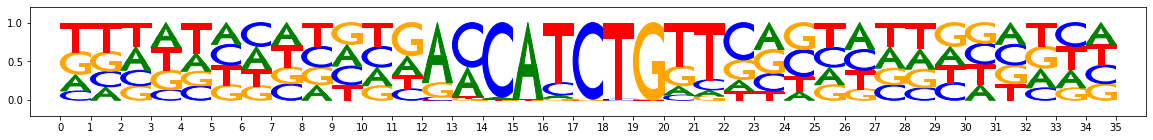

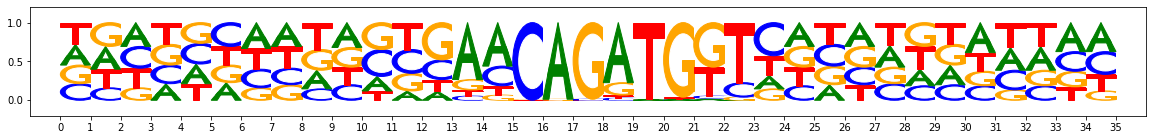

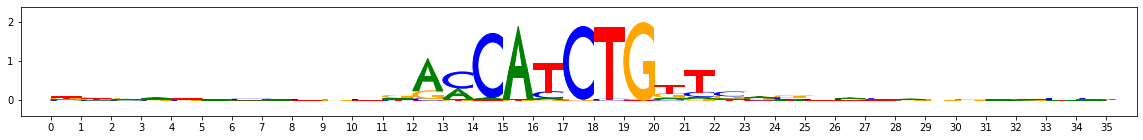

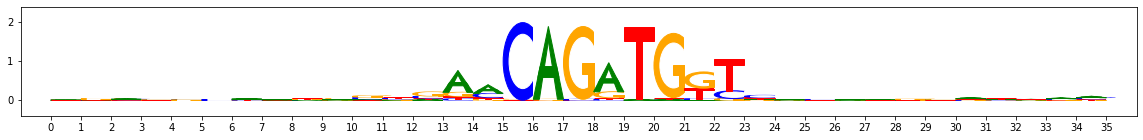

PLOTTING SUBCLUSTERS


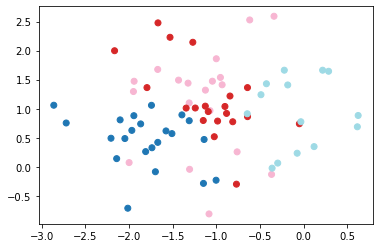

subcluster_0 size 22


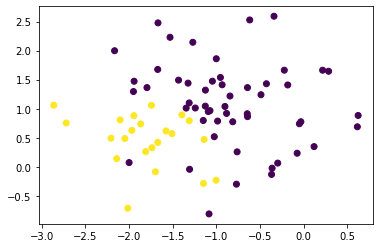

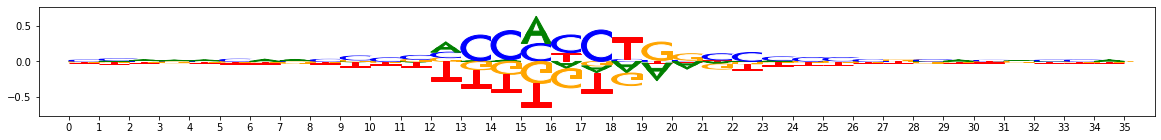

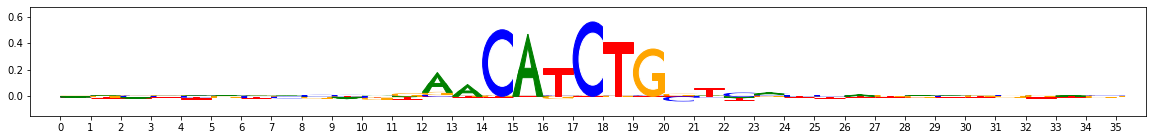

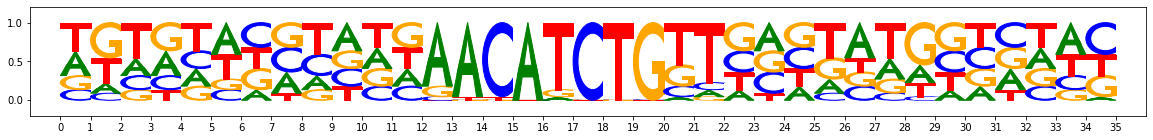

subcluster_1 size 20


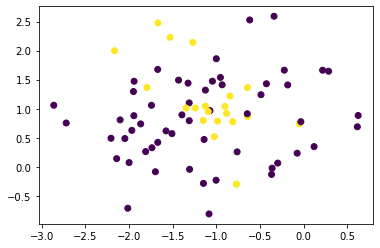

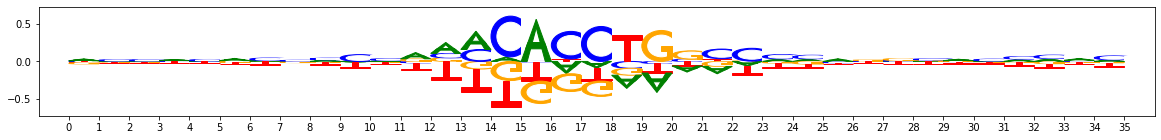

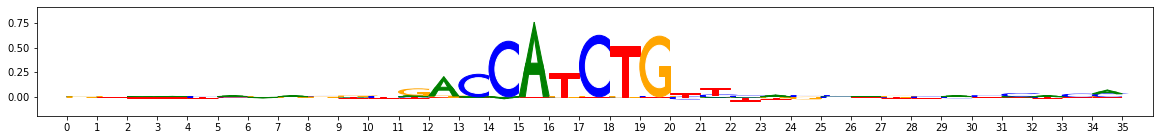

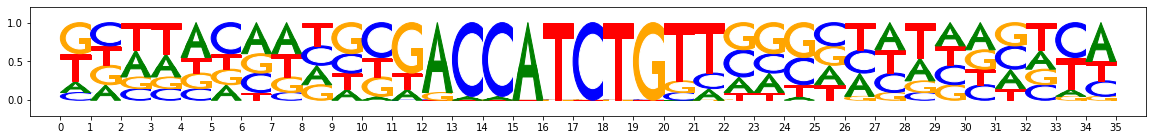

subcluster_2 size 19


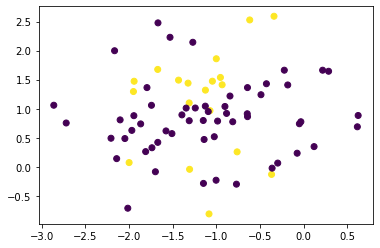

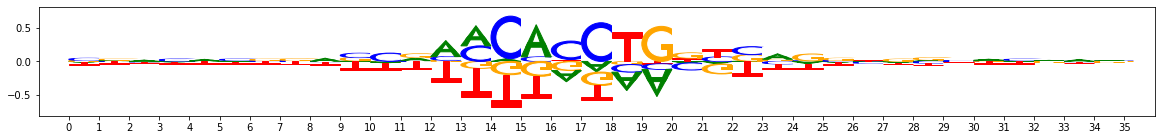

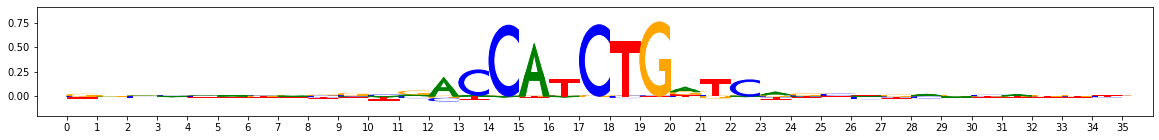

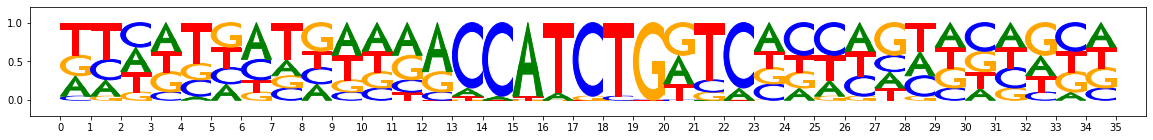

subcluster_3 size 14


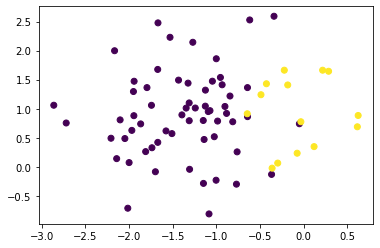

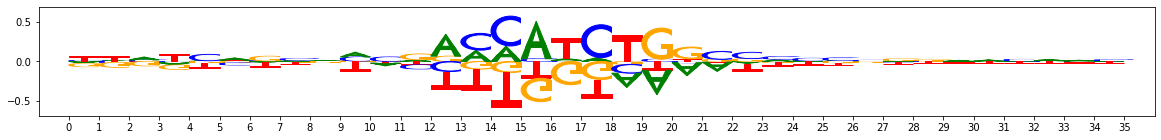

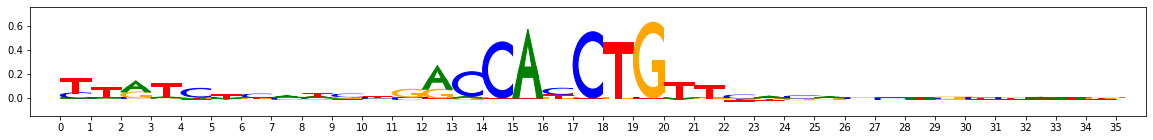

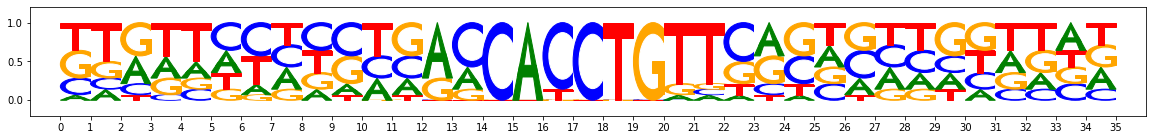

metacluster_0 pattern_1
total seqlets: 68
Task 0 hypothetical scores:


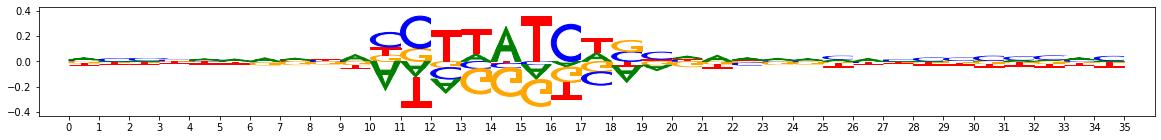

Task 0 actual importance scores:


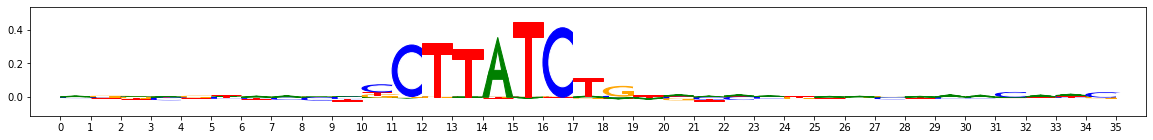

onehot, fwd and rev:


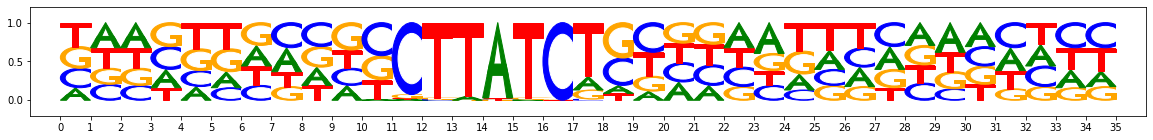

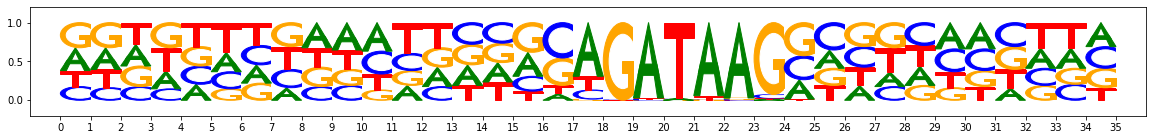

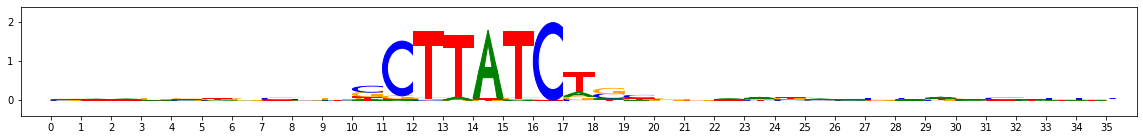

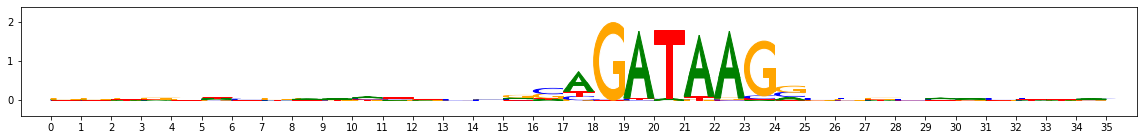

PLOTTING SUBCLUSTERS


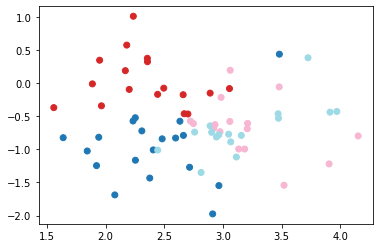

subcluster_0 size 19


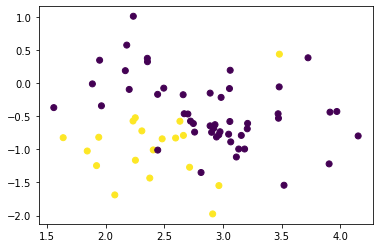

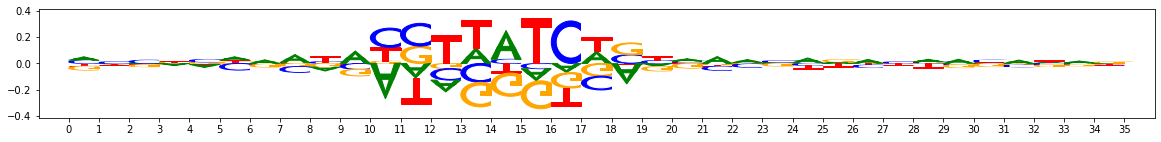

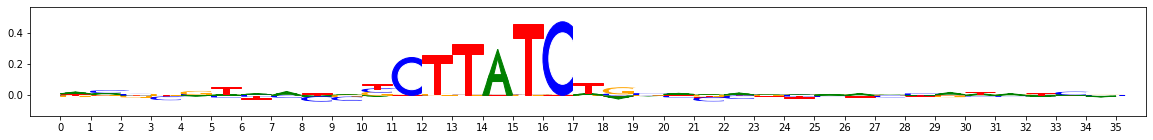

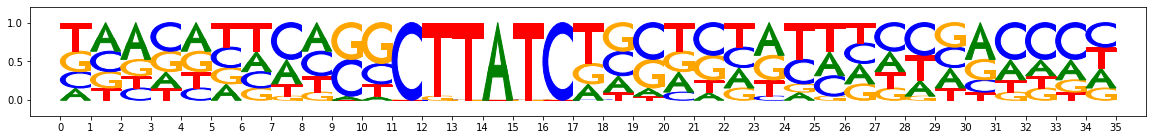

subcluster_1 size 17


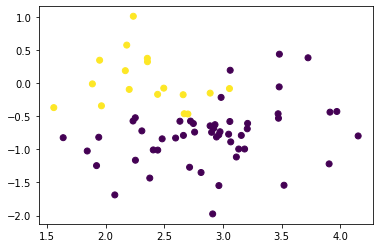

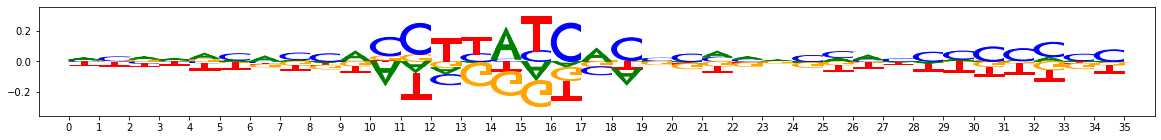

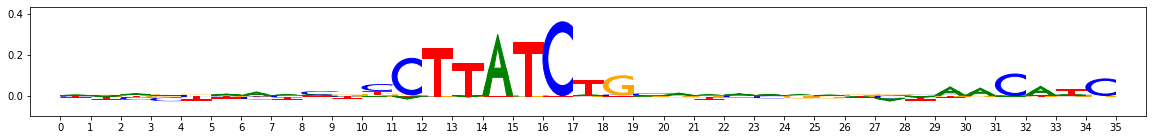

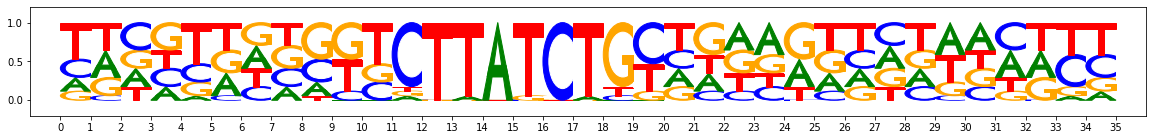

subcluster_2 size 16


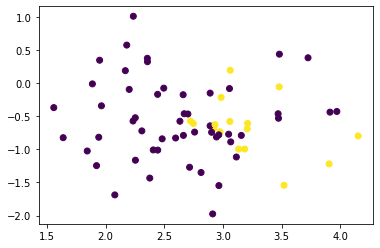

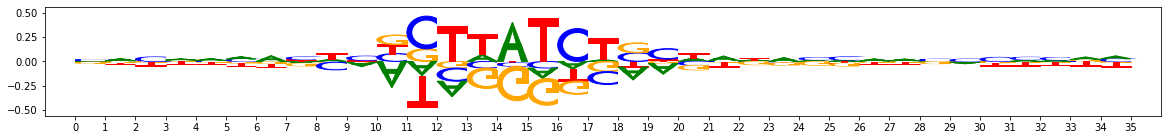

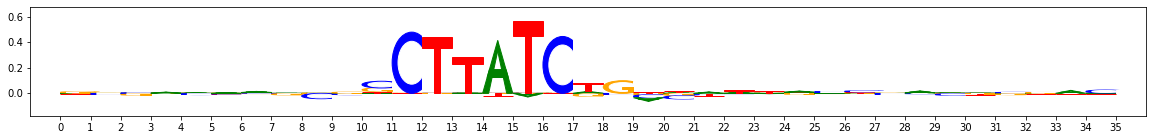

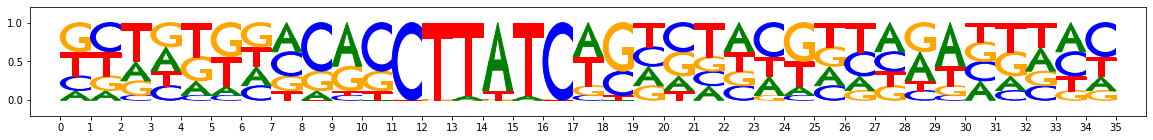

subcluster_3 size 16


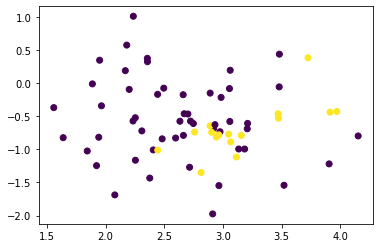

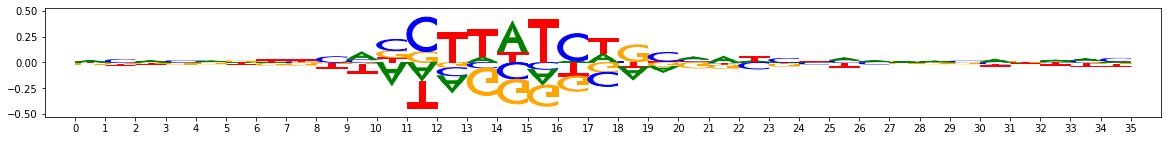

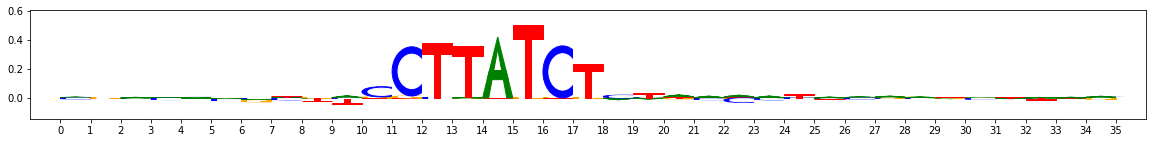

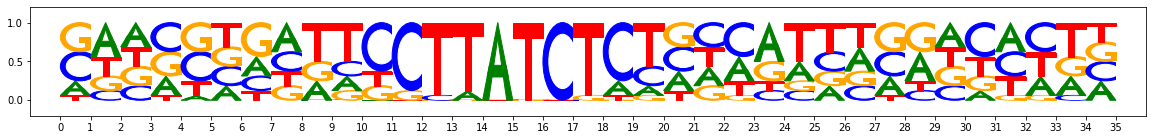

In [9]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(pattern["sequence"]["fwd"])
        viz_sequence.plot_weights(pattern["sequence"]["rev"])
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        #Plot the subclustering too, if available
        if ("subclusters" in pattern):
            print("PLOTTING SUBCLUSTERS")
            subclusters = np.array(pattern["subclusters"])
            twod_embedding = np.array(pattern["twod_embedding"])
            plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
            plt.show()
            for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                plt.show()
                viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
                viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
                viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [8]:
import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

#If loading from a file for which subclusters haven't been computed (e.g. a file produced by an
# earlier version of modisco), you can compute the subclusters by
# following this template:
#patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
#            .seqlets_to_patterns_result.patterns)
#for pattern in patterns:
#    pattern.compute_subclusters_and_embedding(
#                 pattern_comparison_settings=modisco.affinitymat.core.PatternComparisonSettings(                         
#                    track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
#                    track_transformer=modisco.affinitymat.L1Normalizer(),
#                    min_overlap=None), #min_overlap argument is irrelevant here    
#                 perplexity=30, n_jobs=4, verbose=True)

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at https://github.com/kundajelab/tfmodisco/blob/v0.5.13.2/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA_hitscoring.ipynb

Getting trimmed patterns, subclustering them
Trimming the patterns to the target length
Apply subclustering


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    1.1s finished
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'squar

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.001s...
[t-SNE] Computed neighbors for 74 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 0.448291
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 56.2091942, gradient norm = 0.4194291 (50 iterations in 0.016s)
[t-SNE] Iteration 100: error = 50.2608566, gradient norm = 0.5637543 (50 iterations in 0.014s)
[t-SNE] Iteration 150: error = 49.9012337, gradient norm = 0.4412853 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 48.2322769, gradient norm = 0.5737081 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 48.8400116, gradient norm = 0.5724673 (50 iterations in 0.013s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.840012
[t-SNE] Iteration 300: error = 0.8085038, gradient norm = 0.0022707 (50 iterations in 0.011s)
[t-SNE] Iteration 350: error = 0.6983671, gradient norm = 0.0011600 (50 i

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s


Quality: 0.11762606448071856


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  71 out of  71 | elapsed:    0.0s finished


Got subclusters: Counter({0: 22, 1: 20, 2: 17, 3: 15})
[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.001s...
[t-SNE] Computed neighbors for 71 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.477946
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 48.2273560, gradient norm = 0.5778708 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 51.1629257, gradient norm = 0.5268339 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 49.1057968, gradient norm = 0.5647583 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 48.7663727, gradient norm = 0.4103748 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 50.3714066, gradient norm = 0.4696525 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.371407
[t-SNE] Iteration 300: error = 0.8428385, gradient norm = 0.0016383 (50 iterations in 0.011s)
[t-SNE] Iteration 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s


Quality: 0.08766431165147444
Got subclusters: Counter({0: 26, 1: 24, 2: 21})
Preparing seqlet scorer
Pattern length (and hence target seqlet size) is 25
Prepare seqlet scorer
Computing best alignments for all motifseqlets
Launching nearest neighbors affmat calculation job
MEMORY 0.27129856
Parallel runs completed
MEMORY 0.27129856
Job completed in: 0.08 s
MEMORY 0.27129856
Launching nearest neighbors affmat calculation job
MEMORY 0.27129856
Parallel runs completed
MEMORY 0.27129856


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.3s finished


Job completed in: 0.1 s
MEMORY 0.27129856
On seqlets 0 to 145 out of 145


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.85it/s]

0 seqlets out of 145 did not have themselves in their nearest neighbs, likelydue to alignment issues
Insantiating a precision scorer based on fann_perclasssum
Accuracy: 1.0
Insantiating a precision scorer based on fann_perclassavg
Accuracy: 1.0
Launching nearest neighbors affmat calculation job
MEMORY 0.27131904


Parallel runs completed
MEMORY 0.27131904
Job completed in: 0.17 s
MEMORY 0.27131904
Launching nearest neighbors affmat calculation job
MEMORY 0.27131904
Parallel runs completed
MEMORY 0.27131904
Job completed in: 0.19 s
MEMORY 0.27131904
On seqlets 0 to 145 out of 145


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 81.96it/s]

Insantiating a precision scorer based on aggregate sim
Accuracy: 0.5103448275862069
Mapping affinity to distmat
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
Computing density-adapted nn affmat


Beginning preprocessing + Leiden
initclusters length: 145
Affmat shape: 145


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s


Quality: 0.26636554925261885
Quality: 0.266365549252619
Quality: 0.26636554925262224
Quality: 0.2663655492526255
Number of reclustered idxs: 2
{(1, 1), (0, 0)}
Preparing modularity scorer
Accuracy: 1.0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.004282484851777554
Computing threshold


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished


For increasing = True , the minimum IR precision was 0.40826467476677464 occurring at 1.475214958190918e-06 implying a frac_neg of 0.6899447394083867
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.0 occurring at -1.377618222795328e-05 implying a frac_neg of 1.00000010000001e-07
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.5772013366222382  and  0.5322423055768013 with frac passing 0.10850515463917526
Final raw thresholds are -0.5772013366222382  and  0.5322423055768013
Final transformed thresholds are -0.8953092783505154  and  0.8907731958762887


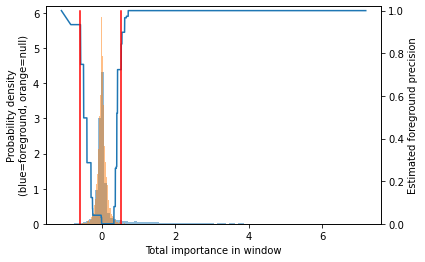

Only returning positive coords!
Got 229 coords


In [9]:
import modisco
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
reload(modisco.coordproducers)
from modisco.visualization import viz_sequence
reload(modisco.aggregator)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
reload(densityadapted_hitscoring)
reload(modisco.cluster.core)

orig_patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns)

#The hit-scorer works in two stages:
# (1) Identifying regions of high importance ("seqlets")
# (2) Mapping those seqlets to patterns (motifs)
#(The two stages are independent of each other)

#instantiate the hit_scorer by providing the patterns
# that identified seqlets will be mapped to. The patterns
# will be trimmed to target_seqlet_size
hit_scorer = densityadapted_hitscoring.MakeHitScorer(
    patterns=orig_patterns,
    target_seqlet_size=25,
    bg_freq=np.mean(onehot_data, axis=(0,1)),
    task_names_and_signs=[("task0",1)],
    n_cores=4)

#set the method used to identify coordinates of high importance ("seqlets")
#You have to provide a contribution score track as this will be used
# to calibrate the threshold used for seqlet identification. You
# can also optionally provide an empirical null distribution track via
# the 'null_track' argument, similar to when tf-modisco is first run.
hit_scorer.set_coordproducer(contrib_scores=task_to_scores,
                             core_sliding_window_size=7,
                             target_fdr=0.2,
                             min_passing_windows_frac=0.03,
                             max_passing_windows_frac=0.2,
                             separate_pos_neg_thresholds=False,                             
                             max_seqlets_total=np.inf)



In [10]:
#Now that the hit-scorer is configured, you can call it on some data to
# get the motif hit calls.
#Note that the values provided to contrib_scores below DO NOT have to be
# the same as the values provided to set_coordproducer above.
#I recommend running this on a small number of regions first to get a feel
# for the runtime; we're still working on improving the runtime here.
(exampleidx_to_matches, patternidx_to_matches) = hit_scorer(
           contrib_scores=task_to_scores,
           hypothetical_contribs=task_to_hyp_scores,
           one_hot=onehot_data,
           hits_to_return_per_seqlet=1)

#Note: if you already have a list of seqlets, you can score them
# using: hit_scorer.seqlet_scorer(seqlets,hits_to_return_per_seqlet=1);
# this will return a 3-tuple of
# (seqlet_matches, patternidx_to_matches, exampleidx_to_matches)

Computing windowed sums on original
Only returning positive coords!
Got 229 coords
Launching nearest neighbors affmat calculation job
MEMORY 0.272928768
Parallel runs completed
MEMORY 0.272928768
Job completed in: 0.34 s
MEMORY 0.272928768
Launching nearest neighbors affmat calculation job
MEMORY 0.272928768
Parallel runs completed
MEMORY 0.272928768
Job completed in: 0.36 s
MEMORY 0.272928768
On seqlets 0 to 229 out of 229


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.42it/s]

Launching nearest neighbors affmat calculation job
MEMORY 0.272928768


Parallel runs completed
MEMORY 0.272928768
Job completed in: 0.19 s
MEMORY 0.272928768
Launching nearest neighbors affmat calculation job
MEMORY 0.272928768
Parallel runs completed
MEMORY 0.272928768
Job completed in: 0.21 s
MEMORY 0.272928768
On seqlets 0 to 229 out of 229


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 59.56it/s]


Removed 1 duplicates


We can now visualize the matches within the sequences.

I am still deciding how to filter out poor-quality matches, and I think some combination of `total_importance` (representing the total importance score in the region of the match), `aggregate_sim` (representing the Continuous Jaccard similarity of the match to the aggregate motif), `fann_perclasssum_perc` (a measure that looks at the percentile rank (relative to the original motif seqlets) of the sum of within-cluster similarities computed at the fine-grained affinity matrix step; fann stands for fine-grained affinity nearest neighbors) and `fann_perclassavg_perc` (a measure that looks at the percentile rank of the *average* within-cluster similarity computed at the fine-grained affinity matrix step) would be useful. Note that although `fann_perclasssum_perc` and `fann_perclassavg_perc` seem identical in the example below, in general they are not, because the number of nearest-neighbors that are within-cluster could vary from one match to the next.

EXAMPLE IDX 0 hits:
Computing windowed sums on original
Only returning positive coords!
Got 3 coords
Original core seqlet locations


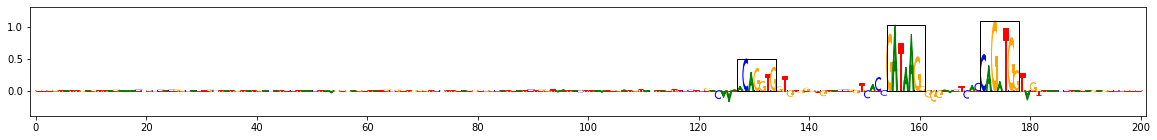

Motif matches (red = without trimming)


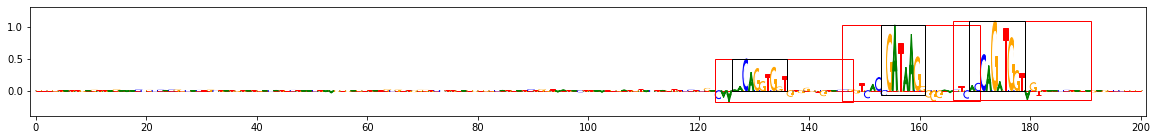

Matches to pattern 0 (the original pattern looks like this:)


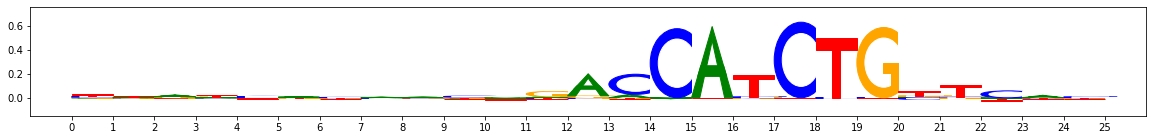

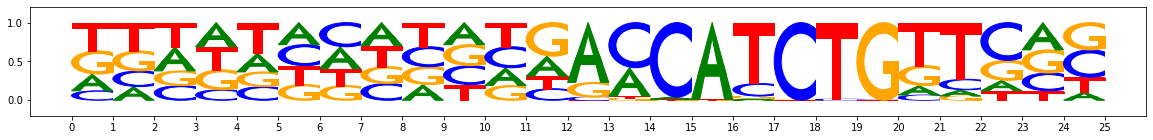

matches in this example...
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.7798247, exampleidx=0, start=123, end=148, trim_start=126, trim_end=136, is_revcomp=True, seqlet_orig_start=118, seqlet_orig_end=143, seqlet_orig_revcomp=False, aggregate_sim=0.46168178387810893, mod_delta=0.0013642551322512117, mod_precision=0.8054430447230262, mod_percentile=0.0, fann_perclasssum_perc=0.3783783783783784, fann_perclassavg_perc=0.33783783783783783)


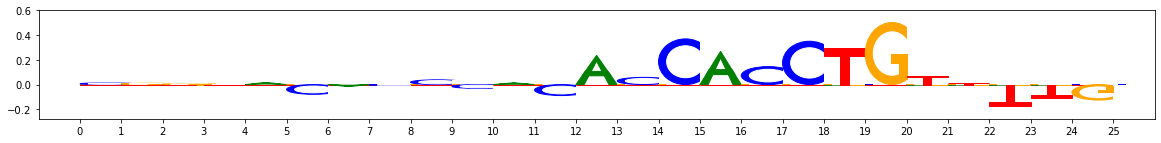

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=4.689957, exampleidx=0, start=166, end=191, trim_start=169, trim_end=179, is_revcomp=True, seqlet_orig_start=162, seqlet_orig_end=187, seqlet_orig_revcomp=False, aggregate_sim=0.5730687286793403, mod_delta=0.0007991591881407242, mod_precision=0.6795393611258067, mod_percentile=0.0, fann_perclasssum_perc=0.7972972972972973, fann_perclassavg_perc=0.7162162162162162)


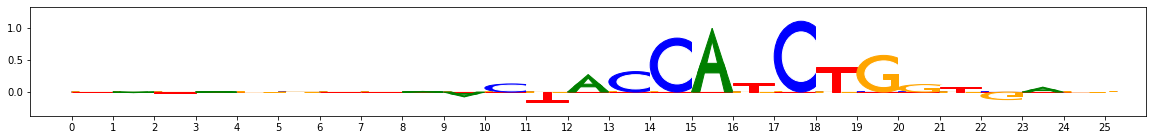

Matches to pattern 1 (the original pattern looks like this:)


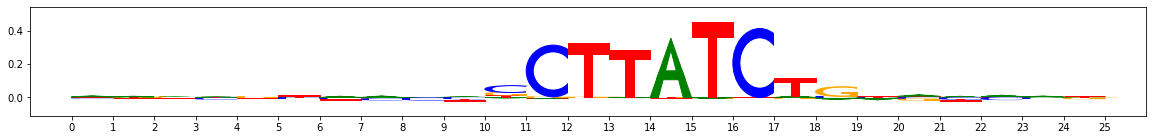

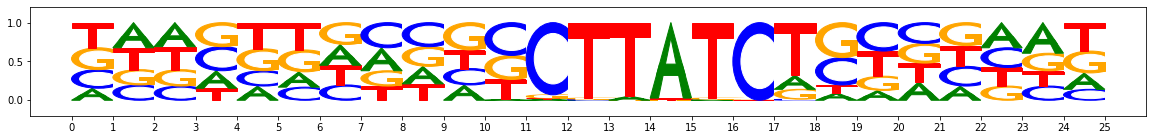

matches in this example...
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=4.541572, exampleidx=0, start=146, end=171, trim_start=153, trim_end=161, is_revcomp=True, seqlet_orig_start=145, seqlet_orig_end=170, seqlet_orig_revcomp=False, aggregate_sim=0.5715020238338483, mod_delta=0.0015691605523846337, mod_precision=0.8481235647469254, mod_percentile=0.0, fann_perclasssum_perc=0.9436619718309859, fann_perclassavg_perc=0.9014084507042254)


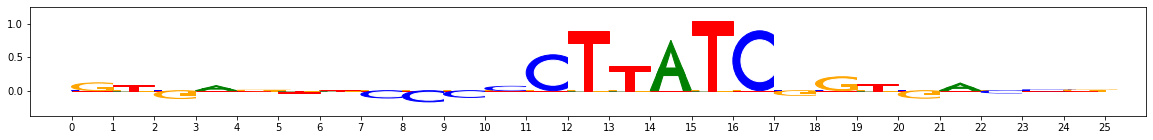

EXAMPLE IDX 1 hits:
Computing windowed sums on original
Only returning positive coords!
Got 3 coords
Original core seqlet locations


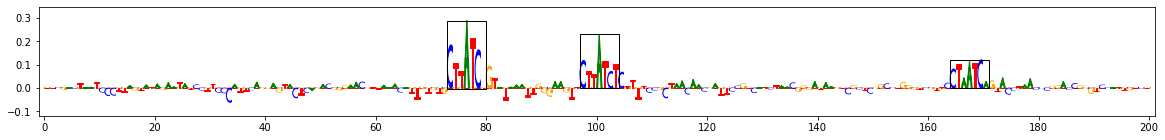

Motif matches (red = without trimming)


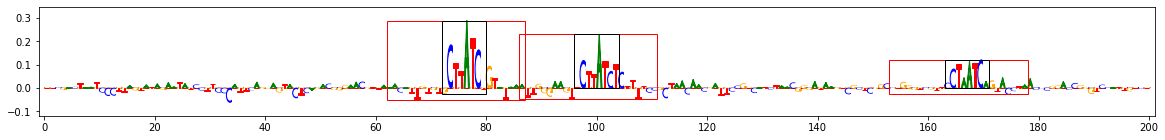

Matches to pattern 1 (the original pattern looks like this:)


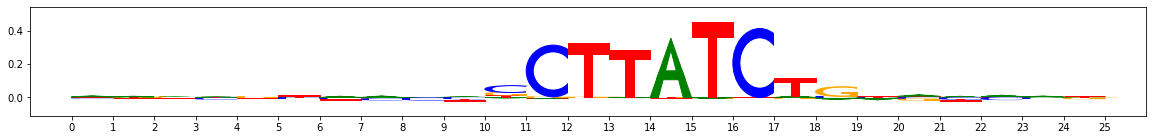

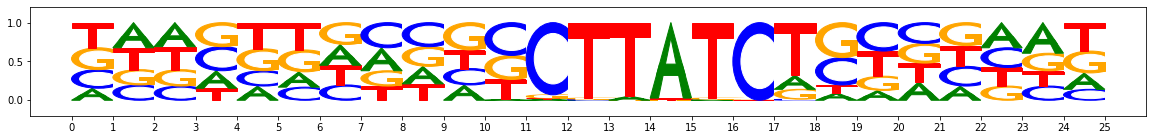

matches in this example...
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.0304018, exampleidx=1, start=62, end=87, trim_start=72, trim_end=80, is_revcomp=False, seqlet_orig_start=64, seqlet_orig_end=89, seqlet_orig_revcomp=False, aggregate_sim=0.38894716519708844, mod_delta=0.000800597530596317, mod_precision=0.6768873056156093, mod_percentile=0.0, fann_perclasssum_perc=0.3802816901408451, fann_perclassavg_perc=0.3380281690140845)


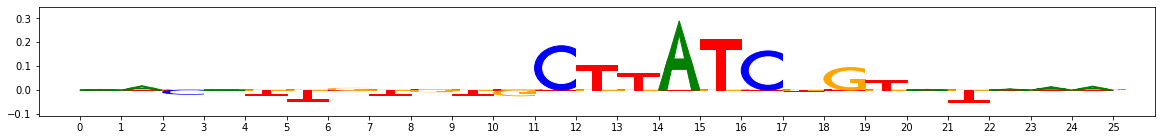

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.7369955, exampleidx=1, start=86, end=111, trim_start=96, trim_end=104, is_revcomp=False, seqlet_orig_start=88, seqlet_orig_end=113, seqlet_orig_revcomp=False, aggregate_sim=0.3499882020263822, mod_delta=0.00048498265453923196, mod_precision=0.6065681396265192, mod_percentile=0.0, fann_perclasssum_perc=0.22535211267605637, fann_perclassavg_perc=0.21126760563380287)


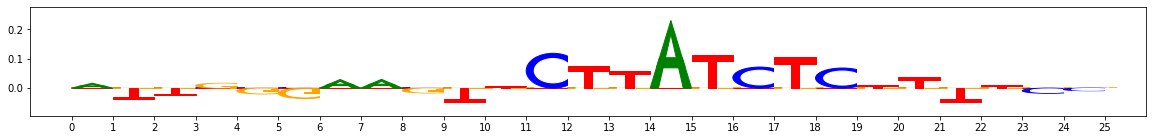

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.6886112, exampleidx=1, start=153, end=178, trim_start=163, trim_end=171, is_revcomp=False, seqlet_orig_start=155, seqlet_orig_end=180, seqlet_orig_revcomp=False, aggregate_sim=0.3203849967897363, mod_delta=0.0006319318546990672, mod_precision=0.6393085013201629, mod_percentile=0.0, fann_perclasssum_perc=0.15492957746478875, fann_perclassavg_perc=0.15492957746478875)


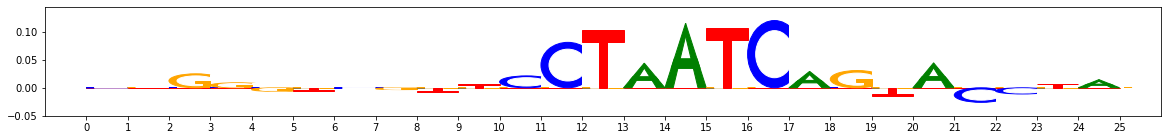

EXAMPLE IDX 2 hits:
Computing windowed sums on original
Only returning positive coords!
Got 3 coords
Original core seqlet locations


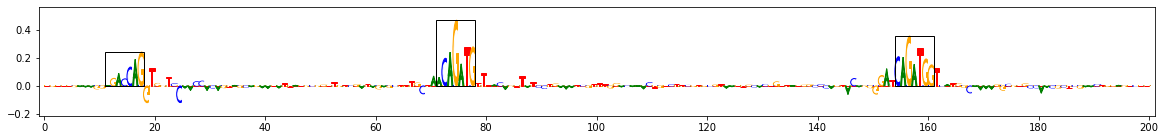

Motif matches (red = without trimming)


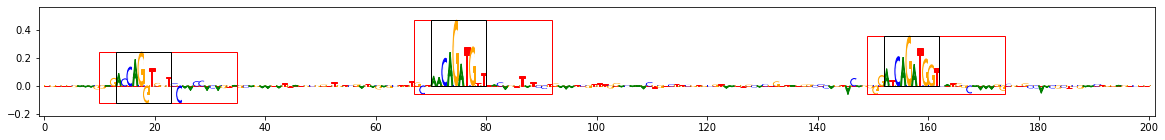

Matches to pattern 0 (the original pattern looks like this:)


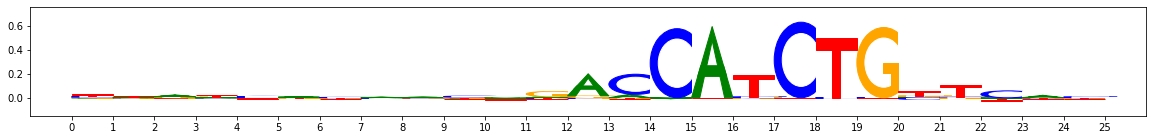

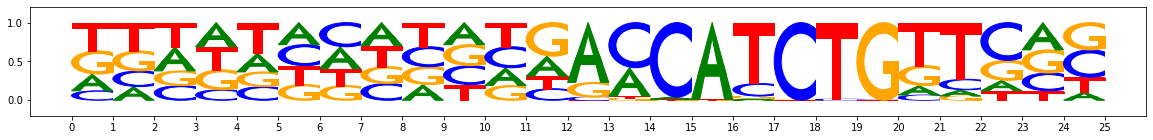

matches in this example...
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=0.6640052, exampleidx=2, start=10, end=35, trim_start=13, trim_end=23, is_revcomp=True, seqlet_orig_start=2, seqlet_orig_end=27, seqlet_orig_revcomp=False, aggregate_sim=0.3927450338373946, mod_delta=0.0007122489211743568, mod_precision=0.6601757063915517, mod_percentile=0.0, fann_perclasssum_perc=0.14864864864864868, fann_perclassavg_perc=0.1351351351351351)


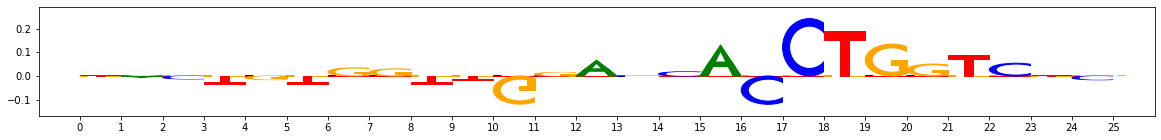

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.9246597, exampleidx=2, start=67, end=92, trim_start=70, trim_end=80, is_revcomp=True, seqlet_orig_start=62, seqlet_orig_end=87, seqlet_orig_revcomp=False, aggregate_sim=0.5555331450824917, mod_delta=0.000910988042198111, mod_precision=0.7044548906124739, mod_percentile=0.0, fann_perclasssum_perc=0.7972972972972973, fann_perclassavg_perc=0.7702702702702703)


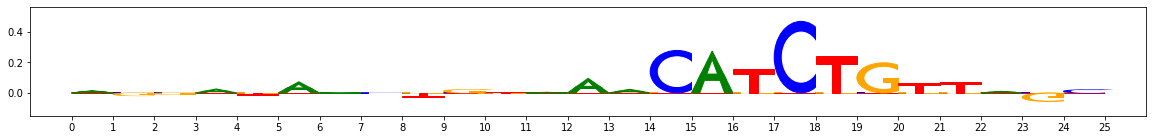

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.7246141, exampleidx=2, start=149, end=174, trim_start=152, trim_end=162, is_revcomp=True, seqlet_orig_start=145, seqlet_orig_end=170, seqlet_orig_revcomp=False, aggregate_sim=0.5241847923945168, mod_delta=0.0010218991808983238, mod_precision=0.7291659526185899, mod_percentile=0.0, fann_perclasssum_perc=0.7567567567567568, fann_perclassavg_perc=0.6891891891891893)


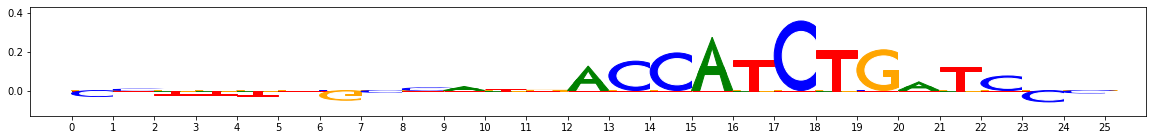

In [11]:
from modisco.visualization import viz_sequence
reload(modisco.coordproducers)

contrib_scores = task_to_scores["task0"]

#visualize the matches
for exampleidx in list(sorted(exampleidx_to_matches.keys()))[:3]: #visualizing the matches in the first 10 seqs
    
    print("EXAMPLE IDX",exampleidx,"hits:")
    matches = exampleidx_to_matches[exampleidx]
    
    coords = hit_scorer.coordproducer(score_track=np.sum(contrib_scores[exampleidx], axis=-1)[None,:],
                                     tnt_results=hit_scorer.tnt_results, null_track=None).coords
    #highlight the locations of all the matches
    print("Original core seqlet locations")
    viz_sequence.plot_weights(
        contrib_scores[exampleidx],
        highlight={'black': [
            (max(x.start+hit_scorer.coordproducer.flank,0),
             min(x.end-hit_scorer.coordproducer.flank,len(contrib_scores[exampleidx])))
             for x in coords]},
        subticks_frequency=20)
    print("Motif matches (red = without trimming)")
    viz_sequence.plot_weights(
        contrib_scores[exampleidx],
        highlight={'red': [
            (max(x.start,0), min(x.end,len(contrib_scores[exampleidx])))
             for x in matches],
                   'black': [
            (max(x.trim_start,0), min(x.trim_end,len(contrib_scores[exampleidx])))
             for x in matches]},
        subticks_frequency=20)
    
    for i in range(len(orig_patterns)):
        matches_to_pattern = [x for x in matches if x.patternidx==i]
        if (len(matches_to_pattern) > 0):
            print("Matches to pattern",i,"(the original pattern looks like this:)")
            viz_sequence.plot_weights(hit_scorer.seqlet_scorer.class_patterns[i]["task0_contrib_scores"].fwd)
            viz_sequence.plot_weights(hit_scorer.seqlet_scorer.class_patterns[i]["sequence"].fwd)
            print("matches in this example...")
            for match in matches_to_pattern:
                print(match)
                if (match.is_revcomp==False):
                    viz_sequence.plot_weights(contrib_scores[exampleidx][match.start:match.end])
                else:
                    viz_sequence.plot_weights(contrib_scores[exampleidx][match.start:match.end][::-1,::-1])

## Inspect the pattern merging hierarchy

Inspect the hierarchy of motif merging events that led to the final motif. Read "Path to node" like a directory structure; all motifs at a similar level in the hierarchy (except for the topmost level) were collapsed together. Any motifs at the topmost level for which the number of seqlets was less than `final_min_cluster_size` were disbanded, and their seqlets were reassigned to the dominant motifs (provided the similarity passed a threshold)

For metacluster 0
Path to node: root/0
Number of seqlets 74


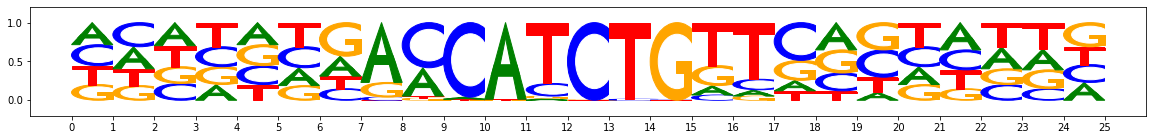

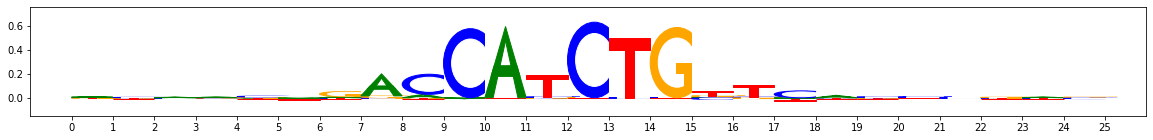

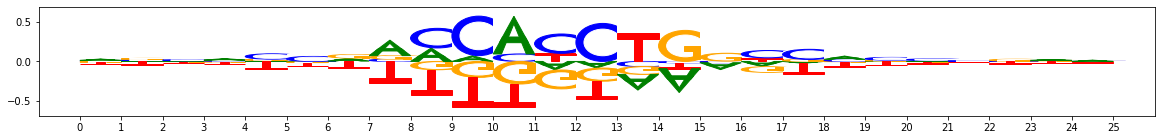

Path to node: root/1
Number of seqlets 71


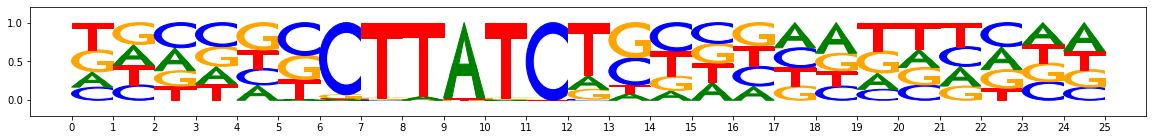

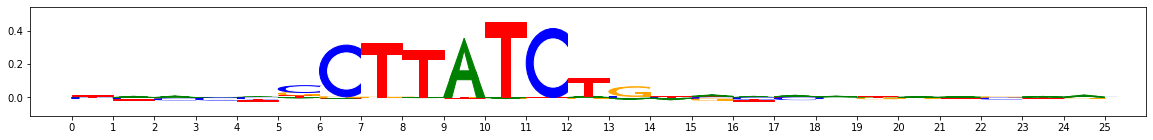

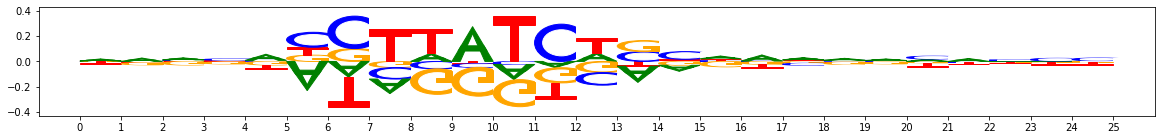

Path to node: root/2
Number of seqlets 3


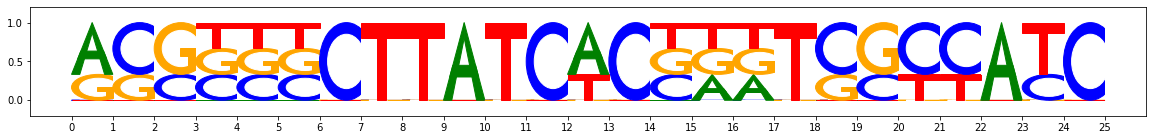

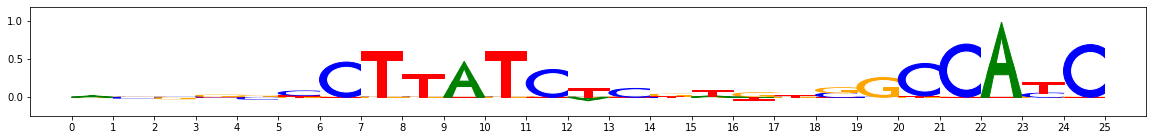

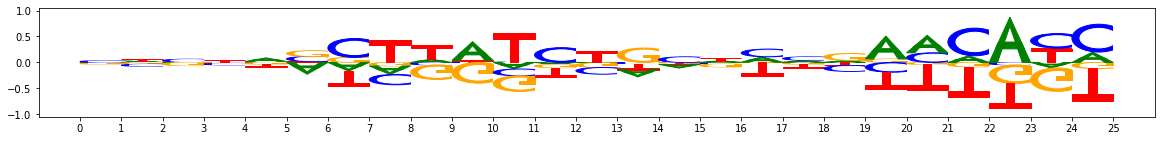

In [12]:
def recursive_plot_hierarchy_motifs(nodes, path):
    for i in range(len(nodes)):
        nodepath = path+"/"+str(i)
        print("Path to node:",nodepath)
        print("Number of seqlets",len(nodes[i].pattern.seqlets))
        if (nodes[i].indices_merged is not None):
            #indices_merged, submat_crosscontam and submat_alignersim can
            # be used to inspect the steps in the merging
            #print("indices merged:",nodes[i].indices_merged)
            #print("submat crosscontam:\n",nodes[i].submat_crosscontam)
            #print("submat alignersim:\n",nodes[i].submat_alignersim)
            pass
        
        #For plotting figures to a png, this code can be used...
        #fig = plt.figure(figsize=(20,5))                                           
        #ax = fig.add_subplot(111)
        #viz_sequence.plot_weights_given_ax(ax, nodes[i].pattern["sequence"].fwd)
        #plt.savefig(nodepath+".png")
        
        viz_sequence.plot_weights(nodes[i].pattern["sequence"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_hypothetical_contribs"].fwd)
        recursive_plot_hierarchy_motifs(nodes[i].child_nodes, path=nodepath)

print("For metacluster 0")
recursive_plot_hierarchy_motifs(loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.pattern_merge_hierarchy.root_nodes,
    path="root")